In [1]:
from itertools import chain

import pandas as pd
import sqlite3
from sklearn.cross_decomposition import PLSCanonical
from sklearn.mixture import BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from matplotlib import animation
import matplotlib as mpl
import scipy as sp

## Constants

In [2]:
color_map = {'acarbose': 'goldenrod', 'control': 'darkblue',
             'UM': 'darkblue', 'UT': 'darkgreen',
             'male': 'blue', 'female': 'magenta',
             'C2013': 'blue', 'Glenn': 'red'}

In [3]:
# Select the data

con1 = sqlite3.connect('data/core.1.denorm.db')

# Relative Abundance
rrs_count = (pd.read_sql('SELECT * FROM rrs_taxon_count;',
                         con=con1, index_col=['extraction_id', 'sequence_id'])
               .tally.unstack().fillna(0).astype(int))
rabund = rrs_count.apply(lambda x: x / x.sum(), axis=1)


extractions = set(rabund.index)
rabund = rabund.loc[extractions]

# Phylotypes
phylotype = pd.read_sql('SELECT sequence_id, otu_id FROM rrs_taxon_count GROUP BY sequence_id;',
                       con=con1, index_col='sequence_id')
name_map = {}
for otu, d in (pd.DataFrame({'mean_rabund': rabund.mean(),
                             'otu_id': phylotype.otu_id})
                 .sort_values('mean_rabund',
                              ascending=False)
                 .groupby('otu_id')):
    for i, sequence_id in enumerate(d.index, start=1):
        name_map[sequence_id] = '{}_{}'.format(otu, i)
phylotype['name'] = pd.Series(name_map)
phylotype['mean_rabund'] = rabund.mean()

taxonomy = pd.read_sql('SELECT sequence_id, phylum_, class_, order_, family_, genus_ FROM rrs_taxonomy;',
                       con=con1, index_col='sequence_id').rename(phylotype.name)

# Select abundant taxa and bins
# TODO: Set these threshold as parameters
major_taxa = phylotype.index[phylotype.mean_rabund > 0.0001]
d_rabund = rabund[major_taxa].copy()
d_rabund['other'] = rabund.drop(columns=major_taxa).sum(1)
d_rabund.rename(columns=phylotype.name, inplace=True)

d_rabund.shape

(373, 468)

In [4]:
extraction = pd.read_sql(
    """
    SELECT *
    FROM extraction
    JOIN sample USING (sample_id)
    JOIN mouse USING (mouse_id);
    """,
    con=con1, index_col='extraction_id'
)

In [5]:
con2 = sqlite3.connect('data/core.muri.2.denorm.db')

feature_extraction_coverage_normalized = (pd.read_sql(
    """
    SELECT
        extraction_id,
        feature_id, 1.0 * SUM(coverage) / SUM(tally) AS normalized_coverage
    FROM feature_library_coverage
    JOIN library USING (library_id)
    JOIN library_size USING (library_id)
    GROUP BY extraction_id, feature_id;
    """,
    con=con2,
    index_col=['extraction_id', 'feature_id']
)
                .squeeze()
                .unstack(fill_value=0))

feature_to_genome = (pd.read_sql(
    'SELECT feature_id, genome_id FROM feature JOIN sequence USING (sequence_id);',
    con=con2,
    index_col=['feature_id']
)
                .squeeze())

/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


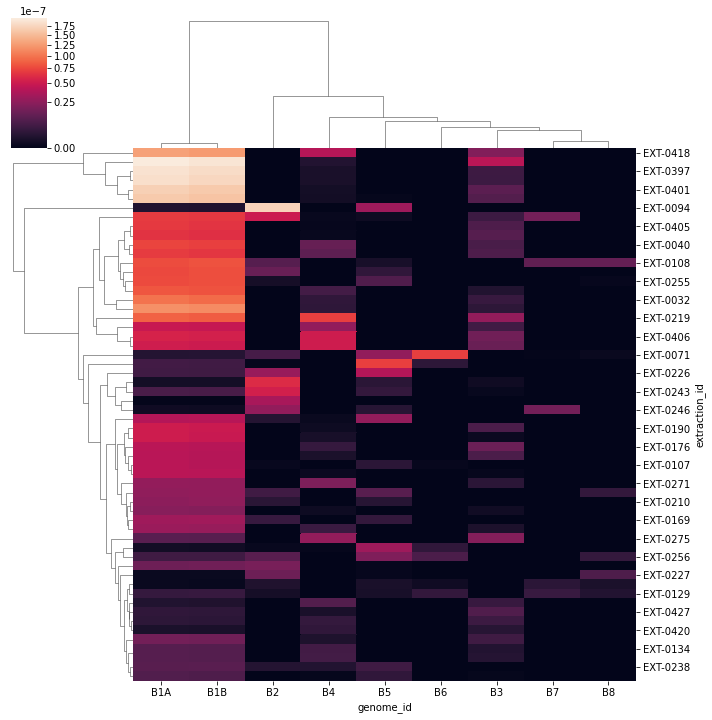

In [6]:
median_feature_coverage = feature_extraction_coverage_normalized.groupby(feature_to_genome, axis='columns').median()
sns.clustermap(median_feature_coverage, norm=mpl.colors.PowerNorm(1/2))

In [7]:
from scipy.spatial.distance import cdist


d1 = median_feature_coverage
d2 = d_rabund.groupby(phylotype.set_index('name').otu_id, axis='columns').sum()

shared_extractions = list(set(d1.index) & set(d2.index))

cos_sim = pd.DataFrame(1 - cdist(d1.loc[shared_extractions].T, d2.loc[shared_extractions].T, metric='cosine'),
                       index=d1.columns, columns=d2.columns)

corr = pd.DataFrame(1 - cdist(d1.loc[shared_extractions].T, d2.loc[shared_extractions].T, metric='correlation'),
                    index=d1.columns, columns=d2.columns)

In [8]:
taxonomy2 = taxonomy.join(phylotype.set_index('name')).drop(columns=['mean_rabund']).drop_duplicates().set_index('otu_id')

In [9]:
cos_sim.idxmax(axis='columns').to_frame(name='best_otu').assign(cosine_similarity=cos_sim.max(axis='columns')).join(taxonomy2, on='best_otu')

,best_otu,cosine_similarity,phylum_,class_,order_,family_,genus_
genome_id,,,,,,,
B1A,Otu0001,0.928659,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
B1B,Otu0001,0.929332,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
B2,Otu0007,0.884812,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
B3,Otu0009,0.921115,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
B4,Otu0005,0.920213,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
B5,Otu0004,0.883707,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
B6,Otu0049,0.967271,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
B7,Otu0017,0.897659,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
B8,Otu0013,0.910010,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge


In [10]:
(
    corr.loc['B1A', 'Otu0001'],
    corr.loc['B1B', 'Otu0001'],
    corr.loc['B2', 'Otu0007'],
    corr.loc['B3', 'Otu0009'],
    corr.loc['B4', 'Otu0005'],
    corr.loc['B5', 'Otu0004'],
    corr.loc['B6', 'Otu0049'],
    corr.loc['B7', 'Otu0017'],
    corr.loc['B8', 'Otu0013'],

)

(0.8681364537953741,
 0.8680006753191635,
 0.8748528871350161,
 0.8886922564693134,
 0.9073331838285559,
 0.8682871559915478,
 0.9675680286613347,
 0.8901498058646378,
 0.903689282321448)

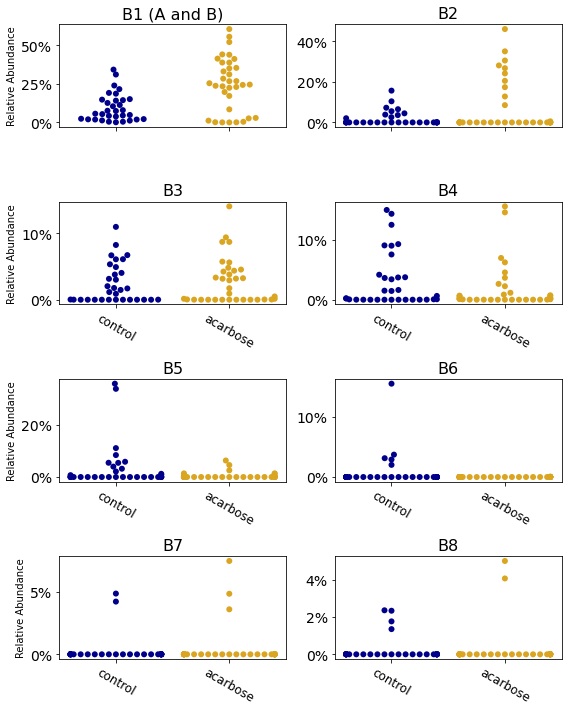

In [11]:
grouper = ['cohort', 'treatment', 'site', 'sex']
muri_otus = ['Otu0001', 'Otu0007', 'Otu0009', 'Otu0005', 'Otu0004', 'Otu0049', 'Otu0017', 'Otu0013']
otu_name_map = {'Otu0001': 'B1 (A and B)',
                'Otu0007': 'B2',
                'Otu0009': 'B3',
                'Otu0005': 'B4',
                'Otu0004': 'B5',
                'Otu0049': 'B6',
                'Otu0017': 'B7',
                'Otu0013': 'B8',
               }
d = (d_rabund
         .groupby(lambda x: x.split('_')[0], axis=1)
         .sum()[muri_otus]
         .join(extraction)
         [lambda x: x.treatment.isin(['acarbose', 'control'])]
         .dropna(subset=['treatment']))
#d['treatment'] = d['treatment'].map

fig, axs = plt.subplots(4, 2, figsize=(8, 10))

for otu, ax in zip(muri_otus, axs.flatten()):
    sns.swarmplot(d['treatment'], d[otu], ax=ax, dodge=True, palette=color_map, size=6)
    ax.set_title(otu_name_map[otu], fontdict=dict(size=16))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=12, labelrotation=-30)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: f'{x:0.0%}'))
    
for ax in axs[0,:]:
    ax.set_xticklabels([])
    
for ax in axs[:,0]:
    ax.set_ylabel('Relative Abundance')
fig.tight_layout()
fig.savefig('fig/otu_aca_response.pdf')

In [19]:
d1 = median_feature_coverage
d2 = d_rabund.groupby(phylotype.set_index('name').otu_id, axis='columns').sum()

shared_extractions = list(set(d1.index) & set(d2.index))

d1.to_csv('build/median_normalized_mag_coverage.tsv', sep='\t')
d2.to_csv('build/otu_relative_abundance.tsv', sep='\t')